<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/mobilenetv2_8.00_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

# Especifique o ID do arquivo e o nome do arquivo de saída
file_id = '1aX48j7lKyE0c66tMZEesOwNncFbyvu6X'
output = 'dataset.zip'

# Baixe o arquivo do Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

!unzip dataset.zip

In [2]:
import numpy as np
import pandas as pd
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2

from sklearn.metrics import classification_report, confusion_matrix

import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = "../content/dataset_3/train"
train_class=os.listdir(train_dir)
print(train_class)

val_dir = "../content/dataset_3/validation"
val_class=os.listdir(val_dir)
print(val_class)

test_dir = "../content/dataset_3/test"
test_class=os.listdir(test_dir)
print(test_class)

['chilli pepper', 'pineapple', 'cucumber', 'capsicum', 'mango', 'cauliflower', 'tomato', 'cabbage', 'bell pepper', 'pomegranate', 'apple', 'eggplant', 'lemon', 'sweetcorn', 'paprika', 'turnip', 'corn', 'grapes', 'onion', 'peas', 'raddish', 'potato', 'spinach', 'soy beans', 'kiwi', 'pear', 'carrot', 'ginger', 'watermelon', 'garlic', 'sweetpotato', 'beetroot', 'orange', 'jalepeno', 'banana', 'lettuce']
['chilli pepper', 'pineapple', 'cucumber', 'capsicum', 'mango', 'cauliflower', 'tomato', 'cabbage', 'bell pepper', 'pomegranate', 'apple', 'eggplant', 'lemon', 'sweetcorn', 'paprika', 'turnip', 'corn', 'grapes', 'onion', 'peas', 'raddish', 'potato', 'spinach', 'soy beans', 'kiwi', 'pear', 'carrot', 'ginger', 'watermelon', 'garlic', 'sweetpotato', 'beetroot', 'orange', 'jalepeno', 'banana', 'lettuce']
['chilli pepper', 'pineapple', 'cucumber', 'capsicum', 'mango', 'cauliflower', 'tomato', 'cabbage', 'bell pepper', 'pomegranate', 'apple', 'eggplant', 'lemon', 'sweetcorn', 'paprika', 'turnip'

In [4]:
x=[] # array value of the images
y=[] # the labels of the images

for folder in os.listdir(train_dir):
    image_list=os.listdir(train_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(train_dir+"/"+folder+"/"+img_name,target_size=(224,224))
        img=image.img_to_array(img)

        # Transfer Learning: Preprocess of MobileNetV2 model to our images before passing it to MobileNetV2
        img=preprocess_input(img)

        x.append(img) # appending image array
        y.append(train_class.index(folder)) # appending class index to the array

print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [5]:
val_images=[]
val_images_Original=[]
val_image_label=[]

for folder in os.listdir(val_dir):
    image_list=os.listdir(val_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(val_dir+"/"+folder+"/"+img_name,target_size=(224,224))

        # Converting to arrarys
        img=image.img_to_array(img)

        # Saving original images, will be used just for display at the end
        val_images_Original.append(img.copy())
        img=preprocess_input(img)

        # Appending arrays
        val_images.append(img)
        val_image_label.append(val_class.index(folder))

print("Preparing Validation Dataset Completed.")

Preparing Validation Dataset Completed.


In [6]:
test_images=[]
test_images_Original=[]
test_image_label=[]

for folder in os.listdir(test_dir):
    image_list=os.listdir(test_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(test_dir+"/"+folder+"/"+img_name,target_size=(224,224))

        # Converting to arrarys
        img=image.img_to_array(img)

        # Saving original images, will be used just for display at the end
        test_images_Original.append(img.copy())
        img=preprocess_input(img)

        # Appending arrays
        test_images.append(img)
        test_image_label.append(test_class.index(folder))

print("Preparing Test Dataset Completed.")

Preparing Test Dataset Completed.


In [7]:
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)

# Validation Dataset
print("Validation Dataset")

val_images=np.array(val_images)
print(val_images.shape)

val_image_label=to_categorical(val_image_label) # onehot encoding of the labels)
print(val_image_label.shape)

print("Test Dataset")

test_images=np.array(test_images)
print(test_images.shape)

test_image_label=to_categorical(test_image_label) # onehot encoding of the labels)
print(test_image_label.shape)

Training Dataset
(3115, 224, 224, 3)
(3115, 36)
Validation Dataset
(351, 224, 224, 3)
(351, 36)
Test Dataset
(359, 224, 224, 3)
(359, 36)


In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=5)
print("Splitting data for train and test completed.")

Splitting data for train and test completed.


In [9]:
rand_images1 = random.sample(os.listdir("../content/dataset_3/train/beetroot"), 8)
rand_images2 = random.sample(os.listdir("../content/dataset_3/train/carrot"), 8)

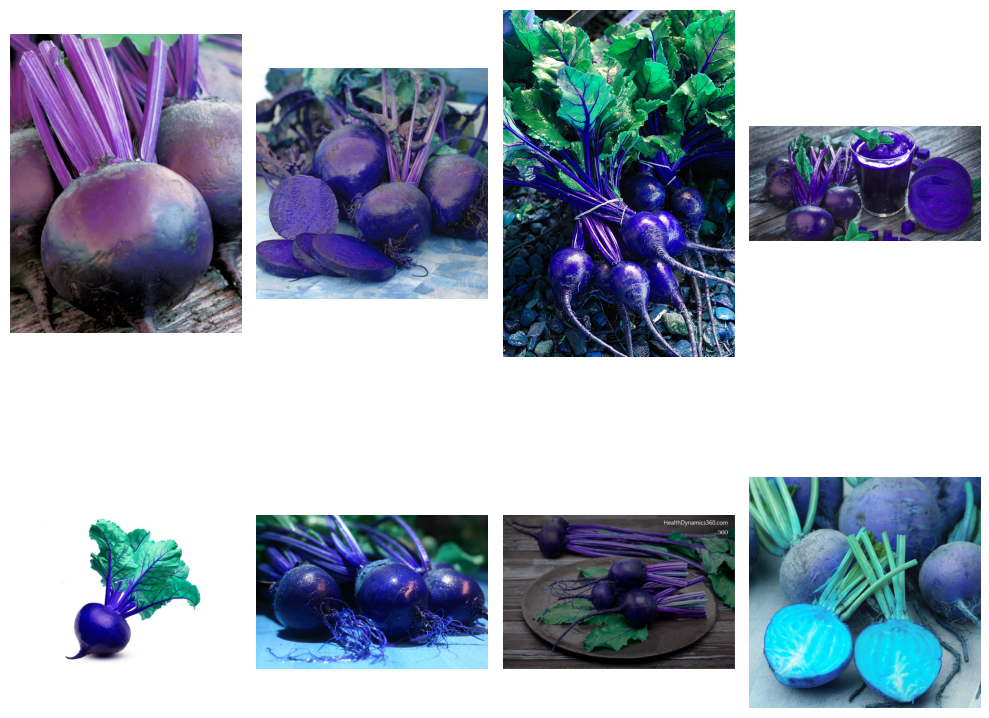

In [10]:
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images1):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("../content/dataset_3/train/beetroot", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

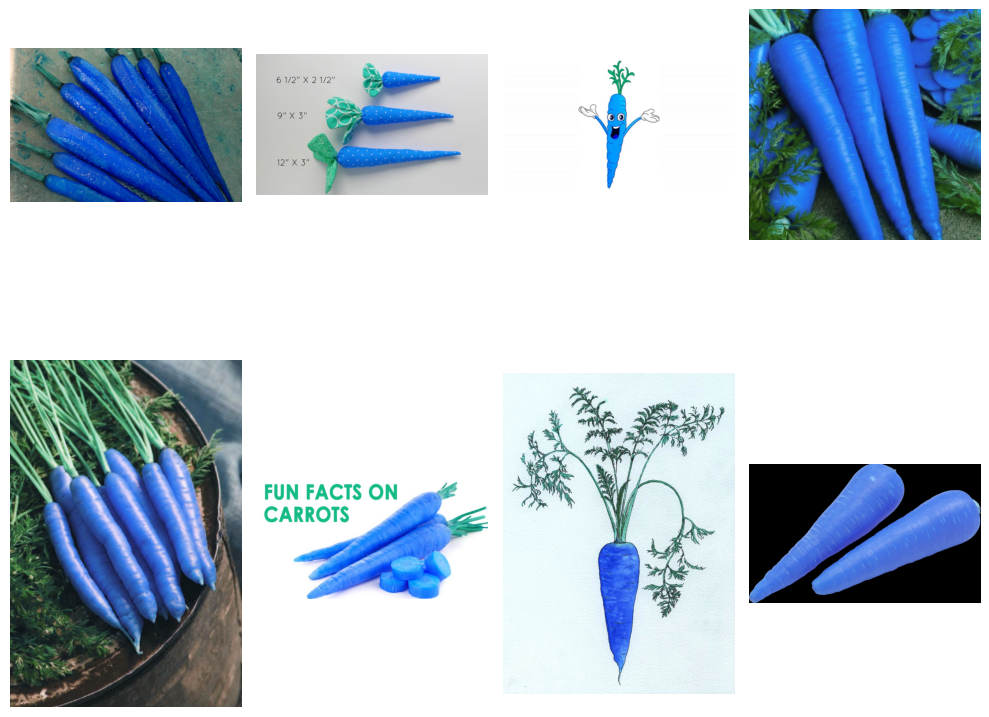

In [11]:
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images2):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("../content/dataset_3/train/carrot", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

9406464/9406464 [==============================] - 1s 0us/step


In [13]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(36, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [14]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [15]:
EPOCHS = 25
hist = model.fit(xtrain, ytrain, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=(xtest,ytest))

Epoch 1/25
78/78 [==============================] - 39s 459ms/step - loss: 1.6198 - accuracy: 0.5706 - val_loss: 0.9920 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 2/25
78/78 [==============================] - 35s 447ms/step - loss: 0.5550 - accuracy: 0.8218 - val_loss: 0.7428 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 3/25
78/78 [==============================] - 35s 448ms/step - loss: 0.3329 - accuracy: 0.8949 - val_loss: 0.6786 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 4/25
78/78 [==============================] - 35s 453ms/step - loss: 0.1986 - accuracy: 0.9426 - val_loss: 0.6421 - val_accuracy: 0.7961 - lr: 1.0000e-04
Epoch 5/25
78/78 [==============================] - 35s 448ms/step - loss: 0.1563 - accuracy: 0.9567 - val_loss: 0.6365 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 6/25
78/78 [==============================] - 35s 444ms/step - loss: 0.1511 - accuracy: 0.9627 - val_loss: 0.6345 - val_accuracy: 0.8026 - lr: 1.0000e-04
Epoch 7/25
78/78 [==============================] - 

In [26]:
# Salvar o modelo ao final do treinamento
model.save("frutas_final.h5")

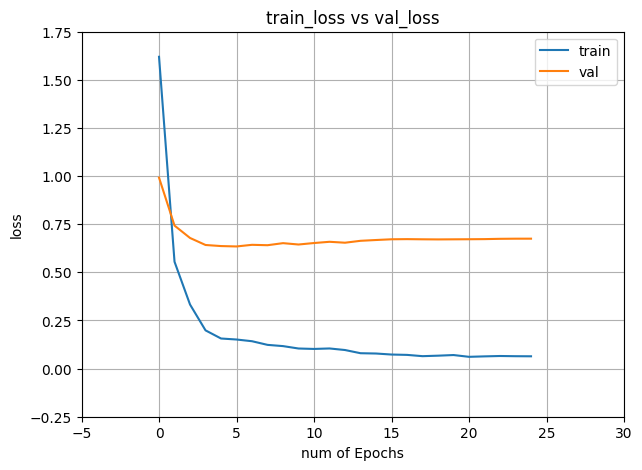

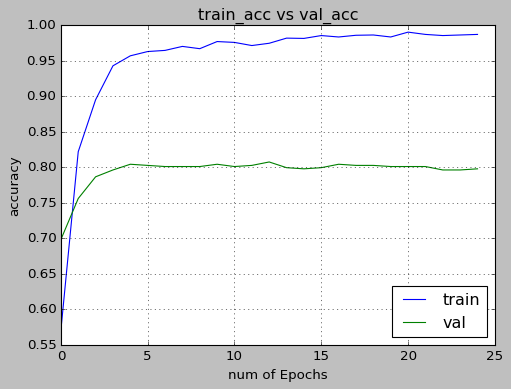

In [17]:
epochs = 25
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [18]:
def predict(img_name, model):
    img=image.load_img(img_name,target_size=(224,224))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=preprocess_input(img)
    prediction=model.predict(img.reshape(1,224,224,3))
    output=np.argmax(prediction)
    print(train_class[output])


# This function plots the image supplied in array
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.astype('int32'))
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

In [19]:
predictions=[]

for img in test_images:
    img=img.reshape(1,224,224,3)
    predictions.append(model.predict(img))

1/1 [==============================] - 0s 46ms/step


In [20]:
pred_labels = model.predict(test_images)

12/12 [==============================] - 4s 357ms/step


In [21]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_image_label, pred_labels, target_names=test_class))

               precision    recall  f1-score   support

chilli pepper       0.91      1.00      0.95        10
    pineapple       1.00      1.00      1.00        10
     cucumber       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
        mango       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00        10
       tomato       0.91      1.00      0.95        10
      cabbage       1.00      1.00      1.00        10
  bell pepper       0.91      1.00      0.95        10
  pomegranate       0.91      1.00      0.95        10
        apple       0.88      0.70      0.78        10
     eggplant       1.00      1.00      1.00        10
        lemon       0.83      1.00      0.91        10
    sweetcorn       0.71      1.00      0.83        10
      paprika       0.77      1.00      0.87        10
       turnip       1.00      1.00      1.00        10
         corn       1.00      0.60      0.75        10
       gr

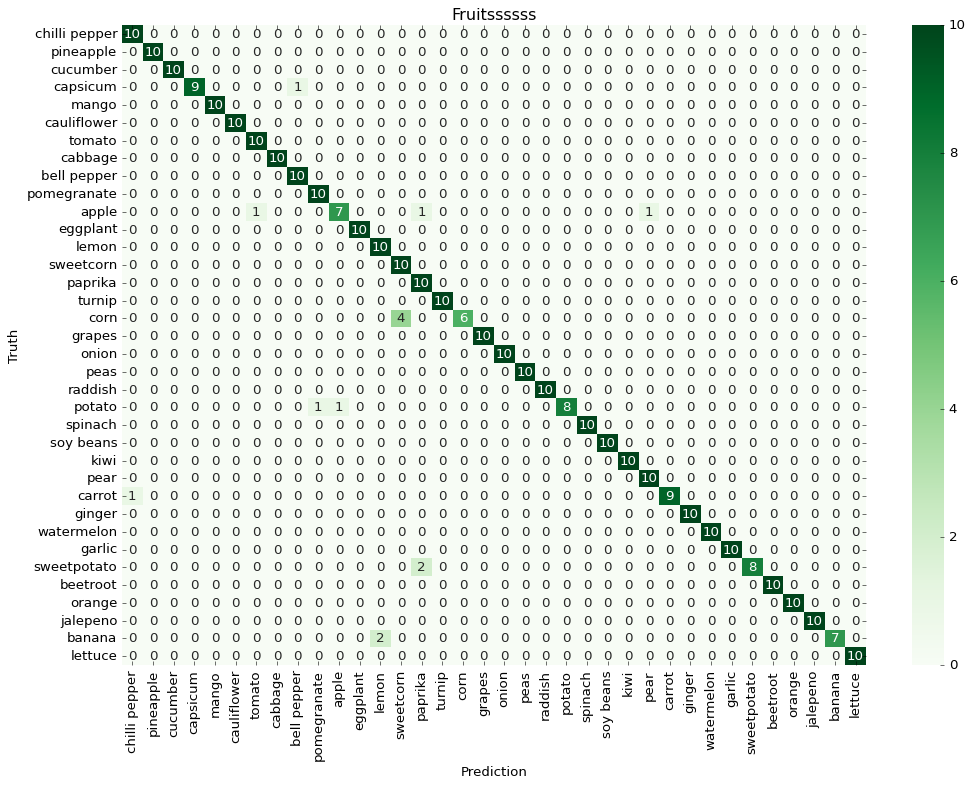

In [22]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_image_label, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

#plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= test_class,
                yticklabels=test_class)

plt.title('Fruitssssss')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

1/1 [==============================] - 1s 965ms/step


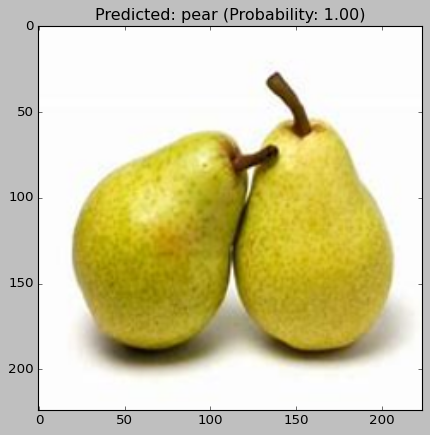

Classe prevista: pear


In [74]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

def predict(image_path, model, class_names):
    # Carregar a imagem
    img = Image.open(image_path)
    img = img.resize((224, 224))

    # Converter a imagem para um array numpy
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Fazer a predição
    prediction = model.predict(img_array)

    # Obter a classe com a maior probabilidade
    predicted_class = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class]

    # Exibir a imagem e a predição
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} (Probability: {prediction[0][predicted_class]:.2f})")
    plt.show()

    # Retornar o nome da classe prevista
    return predicted_class_name

# Carregar o modelo treinado
model = load_model("/content/frutas_final.h5")

# Lista de classes
class_names = ['chilli pepper', 'pineapple', 'cucumber', 'capsicum', 'mango', 'cauliflower', 'tomato', 'cabbage', 'bell pepper', 'pomegranate', 'apple', 'eggplant', 'lemon', 'sweetcorn', 'paprika', 'turnip', 'corn', 'grapes', 'onion', 'peas', 'raddish', 'potato', 'spinach', 'soy beans', 'kiwi', 'pear', 'carrot', 'ginger', 'watermelon', 'garlic', 'sweetpotato', 'beetroot', 'orange', 'jalepeno', 'banana', 'lettuce']

# Chamar a função predict
result_class = predict("../content/imagem_teste/pera03.jpg", model, class_names)

# Imprimir a classe prevista
print("Classe prevista:", result_class)

1/1 [==============================] - 1s 1s/step


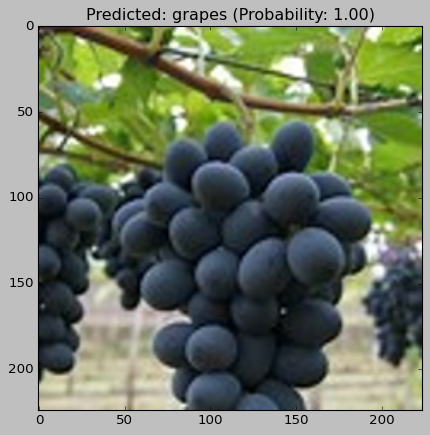

Classe prevista: grapes


In [136]:
#!pip install gtts

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from gtts import gTTS
from IPython.display import Audio, display

def predict(image_path, model, class_names):
    # Carregar a imagem
    img = Image.open(image_path)
    img = img.resize((224, 224))

    # Converter a imagem para um array numpy
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Fazer a predição
    prediction = model.predict(img_array)

    # Obter a classe com a maior probabilidade
    predicted_class = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class]

    # Exibir a imagem e a predição
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} (Probability: {prediction[0][predicted_class]:.2f})")
    plt.show()

    # Retornar o nome da classe prevista
    return predicted_class_name

# Carregar o modelo treinado
model = load_model("/content/frutas_final.h5")

# Lista de classes
class_names = ['chilli pepper', 'pineapple', 'cucumber', 'capsicum', 'mango', 'cauliflower', 'tomato', 'cabbage', 'bell pepper', 'pomegranate', 'apple', 'eggplant', 'lemon', 'sweetcorn', 'paprika', 'turnip', 'corn', 'grapes', 'onion', 'peas', 'raddish', 'potato', 'spinach', 'soy beans', 'kiwi', 'pear', 'carrot', 'ginger', 'watermelon', 'garlic', 'sweetpotato', 'beetroot', 'orange', 'jalepeno', 'banana', 'lettuce']

# Chamar a função predict
result_class = predict("../content/imagem_teste/uva01.jpg", model, class_names)

# Imprimir a classe prevista
print("Classe prevista:", result_class)

# Converter o resultado para áudio
tts = gTTS(text=f"Classe prevista: {result_class}", lang='pt')
tts.save("/content/output.mp3")

# Reproduzir o áudio usando IPython
display(Audio(filename="/content/output.mp3", autoplay=True))

<IPython.core.display.Javascript object>

1/1 [==============================] - 1s 902ms/step


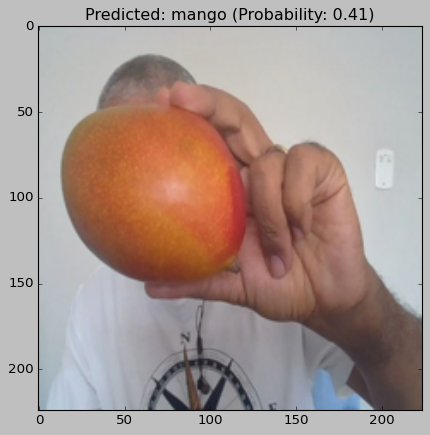

Predicted class: mango


In [106]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def take_photo_and_predict(model, class_names, filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    # Call the predict function with the captured image
    result_class = predict(filename, model, class_names)

    # Print the predicted class
    print("Predicted class:", result_class)

# Function to predict the class of an image
def predict(image_path, model, class_names):
    # Load the image
    img = Image.open(image_path)
    img = img.resize((224, 224))

    # Convert the image to a numpy array
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} (Probability: {prediction[0][predicted_class]:.2f})")
    plt.show()

    # Return the predicted class name
    return predicted_class_name

# Load the pre-trained model and class names
model = load_model("/content/frutas_final.h5")
class_names = ['chilli pepper', 'pineapple', 'cucumber', 'capsicum', 'mango', 'cauliflower', 'tomato', 'cabbage', 'bell pepper', 'pomegranate', 'apple', 'eggplant', 'lemon', 'sweetcorn', 'paprika', 'turnip', 'corn', 'grapes', 'onion', 'peas', 'raddish', 'potato', 'spinach', 'soy beans', 'kiwi', 'pear', 'carrot', 'ginger', 'watermelon', 'garlic', 'sweetpotato', 'beetroot', 'orange', 'jalepeno', 'banana', 'lettuce']

# Call the function to capture an image and predict its class
take_photo_and_predict(model, class_names)


In [135]:
#!apt-get install libzbar0
#!pip install pyzbar
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from pyzbar.pyzbar import decode
import cv2
import numpy as np

def capture_barcode():
    js = Javascript('''
    async function captureBarcode() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('captureBarcode()')
    binary = b64decode(data.split(',')[1])

    # Salvar a imagem temporariamente
    with open('temp.jpg', 'wb') as f:
        f.write(binary)

    # Ler o código de barras na imagem
    image = cv2.imread('temp.jpg', 0)
    decoded_objects = decode(image)
    if decoded_objects:
        for obj in decoded_objects:
            barcode_data = obj.data.decode('utf-8')
            print('Código de barras lido:', barcode_data)
    else:
        print('Nenhum código de barras foi detectado.')

    # Remover a imagem temporária
    import os
    os.remove('temp.jpg')

capture_barcode()

<IPython.core.display.Javascript object>

Código de barras lido: 7296023411821
